In [1]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
from sklearn import preprocessing
import numpy as np
import time
import os
from PIL import Image
import json
from pathlib import Path
import numpy as np
from sklearn.preprocessing import normalize
from datetime import datetime
import random
import matplotlib.pyplot as plt # plt 用於顯示圖片
import matplotlib.image as mpimg # mpimg 用於讀取圖片

In [2]:
# Replace with valid values
#確認以下這些東西有無正確
ENDPOINT = "https://stylervision.cognitiveservices.azure.com/"
training_key = "d7fb9c199bdb4c76952c6cb56b862b47"
prediction_key = "afbc2a74d69247429481db68cb64be3d"
prediction_resource_id = "/subscriptions/14bf462c-fe1a-47c2-a915-5cacdd27e7b1/resourceGroups/styler/providers/Microsoft.CognitiveServices/accounts/stylervision-Prediction"
publish_iteration_name = "Iteration2"
project_id = "0ab92802-381f-49b4-8aa9-499419808db0"
iteration_id = "4132f45c-a95e-4469-98e2-918c110c24c8"

## 範例
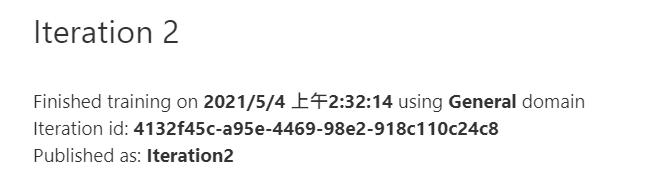

In [3]:
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

In [4]:
# The iteration is now trained. Publish it to the project endpoint
#trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)

trainer.publish_iteration(project_id, iteration_id , publish_iteration_name ,  prediction_resource_id)

print ("Done!")

CustomVisionErrorException: Iteration is already published as: Iteration2

009566.jpg


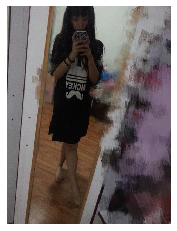

	第1高的標籤：short sleeve dress: 85.82% bbox.left = 0.24, bbox.top = 0.14, bbox.width = 0.34, bbox.height = 0.51
	第2高的標籤：short sleeve top: 33.12% bbox.left = 0.24, bbox.top = 0.09, bbox.width = 0.40, bbox.height = 0.53
	第3高的標籤：trousers: 28.22% bbox.left = 0.29, bbox.top = 0.59, bbox.width = 0.19, bbox.height = 0.23
007150.jpg


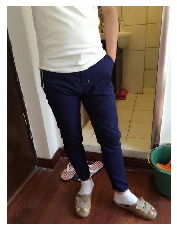

	第1高的標籤：trousers: 87.98% bbox.left = 0.21, bbox.top = 0.23, bbox.width = 0.54, bbox.height = 0.65
	第2高的標籤：short sleeve top: 85.32% bbox.left = 0.10, bbox.top = 0.01, bbox.width = 0.55, bbox.height = 0.32
	第3高的標籤：short sleeve top: 1.02% bbox.left = 0.39, bbox.top = 0.01, bbox.width = 0.30, bbox.height = 0.23
007976.jpg


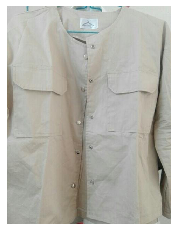

	第1高的標籤：long sleeve outwear: 11.27% bbox.left = 0.05, bbox.top = 0.36, bbox.width = 0.95, bbox.height = 0.61
	第2高的標籤：long sleeve top: 10.46% bbox.left = 0.00, bbox.top = 0.03, bbox.width = 0.97, bbox.height = 0.60
	第3高的標籤：trousers: 9.37% bbox.left = 0.00, bbox.top = 0.36, bbox.width = 0.96, bbox.height = 0.61
003002.jpg


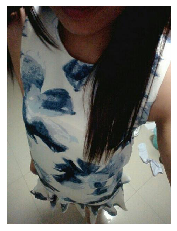

	第1高的標籤：short sleeve top: 41.51% bbox.left = 0.01, bbox.top = 0.38, bbox.width = 0.93, bbox.height = 0.57
	第2高的標籤：shorts: 22.13% bbox.left = 0.17, bbox.top = 0.68, bbox.width = 0.57, bbox.height = 0.27
	第3高的標籤：trousers: 17.85% bbox.left = 0.11, bbox.top = 0.75, bbox.width = 0.59, bbox.height = 0.23
008131.jpg


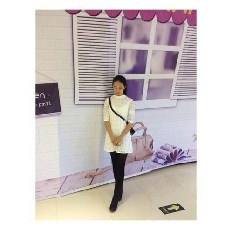

	第1高的標籤：long sleeve top: 85.84% bbox.left = 0.43, bbox.top = 0.40, bbox.width = 0.16, bbox.height = 0.27
	第2高的標籤：trousers: 83.91% bbox.left = 0.44, bbox.top = 0.61, bbox.width = 0.14, bbox.height = 0.31
	第3高的標籤：shorts: 9.31% bbox.left = 0.45, bbox.top = 0.61, bbox.width = 0.14, bbox.height = 0.09
000048.jpg


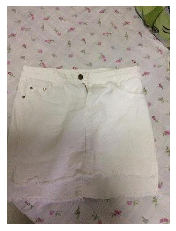

	第1高的標籤：skirt: 14.52% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.95, bbox.height = 0.62
	第2高的標籤：shorts: 14.19% bbox.left = 0.00, bbox.top = 0.25, bbox.width = 0.95, bbox.height = 0.60
	第3高的標籤：vest: 10.57% bbox.left = 0.00, bbox.top = 0.25, bbox.width = 0.95, bbox.height = 0.60
003722.jpg


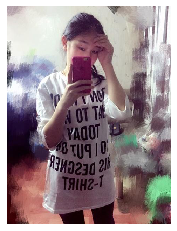

	第1高的標籤：trousers: 70.80% bbox.left = 0.24, bbox.top = 0.72, bbox.width = 0.44, bbox.height = 0.26
	第2高的標籤：short sleeve top: 30.11% bbox.left = 0.18, bbox.top = 0.22, bbox.width = 0.54, bbox.height = 0.48
	第3高的標籤：short sleeve dress: 12.95% bbox.left = 0.18, bbox.top = 0.22, bbox.width = 0.53, bbox.height = 0.57
009114.jpg


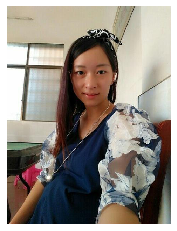

	第1高的標籤：short sleeve top: 60.65% bbox.left = 0.19, bbox.top = 0.42, bbox.width = 0.56, bbox.height = 0.48
	第2高的標籤：shorts: 39.43% bbox.left = 0.53, bbox.top = 0.76, bbox.width = 0.30, bbox.height = 0.23
	第3高的標籤：long sleeve top: 24.48% bbox.left = 0.10, bbox.top = 0.41, bbox.width = 0.89, bbox.height = 0.58
001138.jpg


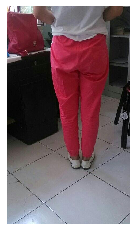

	第1高的標籤：short sleeve top: 82.95% bbox.left = 0.26, bbox.top = 0.00, bbox.width = 0.71, bbox.height = 0.17
	第2高的標籤：trousers: 74.69% bbox.left = 0.32, bbox.top = 0.16, bbox.width = 0.51, bbox.height = 0.54
	第3高的標籤：trousers: 1.43% bbox.left = 0.47, bbox.top = 0.57, bbox.width = 0.27, bbox.height = 0.17


In [5]:
# Now there is a trained endpoint that can be used to make a prediction

# Open the sample image and get back the prediction results.
test_path ="C:/Users/JIALI/Desktop/project/VProject/validation/image/"
   
def quicktest():
    
    img = str(random.randint(0,9999)).zfill(6)+".jpg"
    lena = mpimg.imread(test_path+img)
    plt.imshow(lena)
    plt.axis('off') # 不顯示座標軸
    print(img)
    plt.show()
    with open(test_path+img, mode="rb") as test_data:#記得改project id
        results = predictor.detect_image(project_id,publish_iteration_name, test_data)
   
    count = 1
# Display the results.    
    for prediction in results.predictions:
        if(count<4):
            print("\t第"+str(count)+"高的標籤：" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))
            count = count+1
#         else:
#             print("\t" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))

for i in range(1,10):
    quicktest()